In [1]:
from typing import Tuple, List, Dict
import os
import datetime


import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import (alexnet,
                                AlexNet_Weights,
                                resnet18,
                                ResNet18_Weights,
                                ResNet,
                                resnet101)

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import numpy as np
import skimage.io
from PIL import Image 
import matplotlib.pyplot as plt

In [2]:
from typing import Tuple

import torch
import torch.nn as nn
from torchvision.models import (resnet18,
                                ResNet18_Weights,
                                ResNet,
                                resnet101)


########### Base class

class NeuralImageCompressor(nn.Module):
    def __init__(self,
                 encoder: nn.Module,
                 decoder: nn.Module,
                 normalising_activation: nn.Module = nn.Sigmoid(),
                 B: int = 1):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.normalising_activation = normalising_activation
        self.B = B
            
    def _get_quantization_error(self, shape: Tuple[int, ...]):
        mean = torch.full(shape, -0.5)
        std = torch.full(shape, 0.5)
        quan_err = 0.5**self.B * torch.normal(mean = mean, std = std)
        return quan_err
    
    def freeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = False
    
    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.normalising_activation(out)
        quant_err = self._get_quantization_error(out.shape).to(out.device)
        out = out + quant_err
        out = self.decoder(out)
        return out



############### Blocks


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, img: torch.Tensor):
        return self.double_conv(img)
    
    
class SimpleResidualUpsampleDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, up_func_name = "upsample"):
        super().__init__()
        if mid_channels is None:
            mid_channels = out_channels
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.upscale = self.make_upscaler(in_channels, out_channels, up_func_name)
        self.conv_to_match_dims = nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=2, stride=2)

    @staticmethod
    def make_upscaler(in_channels, out_channels, up_func_name):
        if up_func_name == "upsample":
            return nn.Upsample(
                scale_factor=2,
                mode='nearest')
        
        elif up_func_name == "deconv":
            return nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=2, stride=2)
        
        else:
            raise ValueError(f"unknown upscaler {up_func_name}")
        
        
    def forward(self, x):
        skip_connection = self.conv_to_match_dims(x)
        out = self.upscale(x)
        out = self.double_conv(out)
        out = out + skip_connection
        return out
    

############### Decoders


class SequentialDecoder8x(nn.Module):
    def __init__(self, in_channels, up_func_name = "deconv"):
        super().__init__()
        out_chan_nums = [512, 256, 128, 64, 3]
        
        decoder_modules = []

        for out_channels in out_chan_nums:
            # мб было бы красивее здесь создавать upscaler
            decoder_modules.append(
                nn.Sequential(
                    self.make_upscaler(in_channels, in_channels, up_func_name),
                    DoubleConv(in_channels=in_channels, out_channels=out_channels),
                )
            )
            in_channels = out_channels

        self.decoder = nn.Sequential(*decoder_modules)
    
    @staticmethod
    def make_upscaler(in_channels, out_channels, up_func_name):
        if up_func_name == "upsample":
            return nn.Upsample(
                scale_factor=2,
                mode='nearest'
            )
        
        elif up_func_name == "deconv":
            return nn.ConvTranspose2d(
                in_channels, out_channels, kernel_size=2, stride=2)
        
        else:
            raise ValueError(f"unknown upscaler {up_func_name}")
    
    def forward(self, img: torch.Tensor):
        return self.decoder(img)



class SimpleResidualDecoder8x(nn.Module):
    def __init__(self, in_channels, up_func_name = "upsample"):
        super().__init__()
        out_chan_nums = [512, 256, 128, 64, 3]
        
        decoder_modules = []

        for out_channels in out_chan_nums:
            # мб было бы красивее здесь создавать upscaler
            decoder_modules.append(
                SimpleResidualUpsampleDoubleConv(
                    in_channels=in_channels,
                    out_channels=out_channels)
            )
            in_channels = out_channels

        self.decoder = nn.Sequential(*decoder_modules)
    
    def forward(self, img: torch.Tensor):
        return self.decoder(img)



# def simple_decoder_8x_upsample_constructor(in_chan_num):
#     out_chan_nums = [512, 256, 128, 64, 3]

#     decoder_modules = []

#     for out_chan_num in out_chan_nums:
#         decoder_modules.append(
#             nn.Sequential(
#                 nn.Upsample(
#                     scale_factor=2,
#                     mode='nearest'
#                 ),
#                 nn.Conv2d(in_channels=in_chan_num,
#                           out_channels=out_chan_num,
#                           kernel_size=3, stride=1, padding=1),
#                 nn.ReLU()
#             )
#         )

#         in_chan_num = out_chan_num
    
#     return nn.Sequential(*decoder_modules)



############# Encoders
    

def resnet_encoder_constructor(resnet):
    return nn.Sequential(
        resnet.conv1,
        resnet.bn1,
        resnet.relu,
        resnet.maxpool,
        resnet.layer1,
        resnet.layer2,
        resnet.layer3,
        resnet.layer4)



############# NeuralImageCompressor (Autoencoders)


def create_resnet_autoencoder(resnet: ResNet, decoder = None, decoder_in_channels: int = 512,
                              normalising_activation: nn.Module = nn.Sigmoid(), B: int = 16,
                              up_func_name = "upsample"):
    resnet_encoder = resnet_encoder_constructor(resnet)
    if decoder is None:
        decoder = SimpleResidualDecoder8x(decoder_in_channels, up_func_name = up_func_name)
    resnet_autoencoder = NeuralImageCompressor(resnet_encoder, decoder, normalising_activation, B)
    return resnet_autoencoder

In [10]:
resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT),
                                              up_func_name = "upsample")

test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [11]:
resnet_autoencoder = create_resnet_autoencoder(resnet18(weights=ResNet18_Weights.DEFAULT))

test_image = torch.rand(3, 64, 64)
resnet_autoencoder(test_image.unsqueeze(0)).shape

torch.Size([1, 3, 64, 64])

In [12]:
# def get_output_channels_of_resnet_encoder(resnet_encoder):
#     num_out_channels = None
#     for module in reversed(resnet_encoder[-1][-1]):
#         if isinstance(module, nn.Conv2d):
#             last_conv = module
#             num_out_channels = module.out_channels
#     return num_out_channels

In [12]:
class ImageFolderSelectedDirs(Dataset):
    def __init__(self, root, dirs=None, transform=None):
        self.root = root
        self.dirs = dirs
        self.transform = transform
        self.images = []
        self._set_images()
    
    def _set_images(self):
        for dir_name in self.dirs:
            dir_path = os.path.join(self.root, dir_name)
            for filename in os.listdir(dir_path):
                self.images.append(
                    os.path.join(
                        dir_path,
                        filename))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.get_image(idx)
        
        if self.transform:
            image = self.transform(image)
        return image
    
    def get_image(self, idx):
        image_path = self.images[idx]
        image = skimage.io.imread(image_path)
        
        # There are grayscale images in ImageNet
        if len(image.shape) == 2 or image.shape[2] ==1:
            image = self.convert_1ch_to_3ch(image)
        image = Image.fromarray(image)
        return image
    
    @staticmethod
    def convert_1ch_to_3ch(image):
        return np.dstack([image, image, image])

In [13]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
imagenet_normalize = transforms.Normalize(imagenet_mean, imagenet_std)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.5, 1.0), ratio=(1.0, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    'val': transforms.Compose([
        transforms.RandomResizedCrop(size = (256, 256), scale=(0.08, 1.0), ratio=(1., 1.)),
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    
    'test': transforms.Compose([
        transforms.ToTensor(),
        imagenet_normalize
    ]),
    
}

In [15]:
# datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
# dirs = dirname_to_classname.keys() 
# phases = ["train", "val"]

# dataset_paths = {phase: os.path.join(datasets_path, phase) for phase in phases}
# datasets = {phase: ImageFolderSelectedDirs(root = dataset_paths[phase], dirs = dirs, transform = data_transforms[phase]) for phase in phases}

In [35]:
# source: https://image-net.org/challenges/LSVRC/2011/browse-synsets.php

dirname_to_classname = {
    "n02486410": "baboon",
    "n07720875": "bell pepper",
    "n03124170": "cowboy hat, ten-gallon hat",
    
    "n02493509": "titi, titi monkey",
    "n02110627": "affenpinscher, monkey pinscher, monkey dog",
    "n02493793": "spider monkey, Ateles geoffroyi",
    "n02480855": "gorilla, Gorilla gorilla",
    
    "n07742313": "Granny Smith",
    "n03724870": "mask",
    "n03379051": "football helmet",
    "n04356056": "sunglasses, dark glasses, shades",
    "n04591157": "Windsor tie",
    "n02906734": "broom"
}

In [36]:
# for k in dirname_to_classname.keys():
#     print(f"{k} in class_indx = {k in class_idxs}")

class_idxs = os.listdir("/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/train")
all(k in class_idxs for k in dirname_to_classname.keys())

True

In [37]:
datasets_root = "/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
dirs = dirname_to_classname.keys() 
phases = ["train", "val"]

train_data_transform = data_transforms["train"]
train_dataset_path  = os.path.join(datasets_root, "train")
train_dataset = ImageFolderSelectedDirs(
    root = train_dataset_path,
    dirs = dirs,
    transform = train_data_transform)

In [38]:
len(train_dataset)

16467

In [39]:
train_dataset[3150].shape

torch.Size([3, 256, 256])

In [40]:
type(train_dataset.get_image(3150))

PIL.Image.Image

In [41]:
type(train_dataset[3150])

torch.Tensor

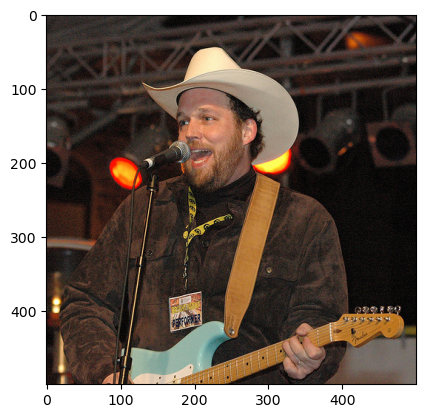

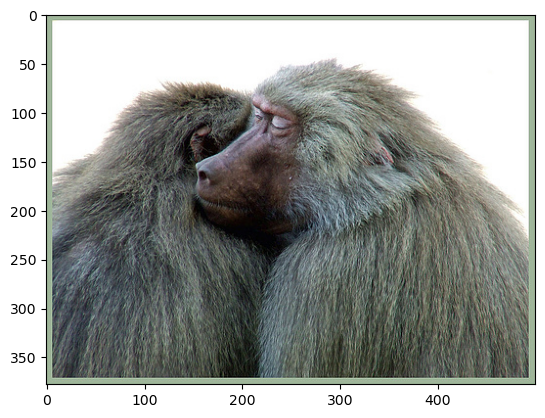

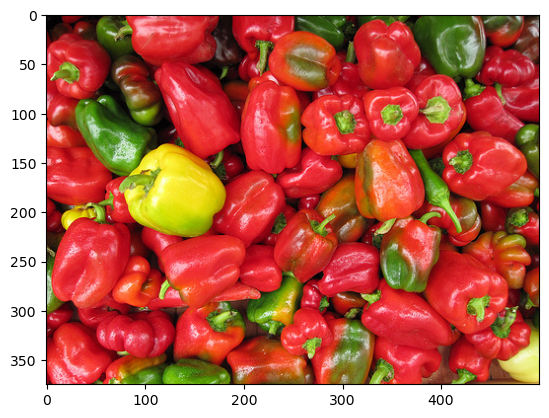

In [42]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset.get_image(3150))
plt.show()
plt.imshow(train_dataset.get_image(120))
plt.show()
plt.imshow(train_dataset.get_image(1390))
plt.show()

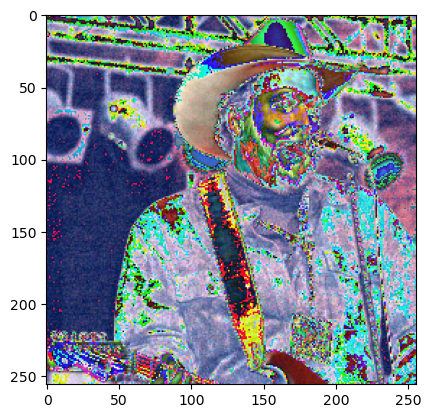

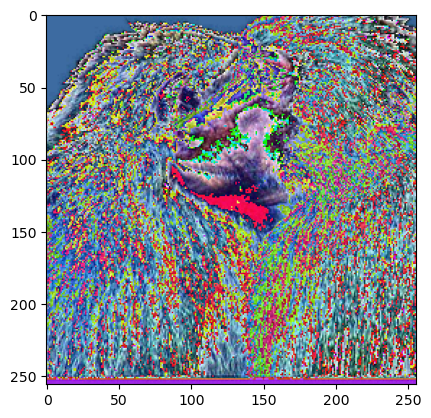

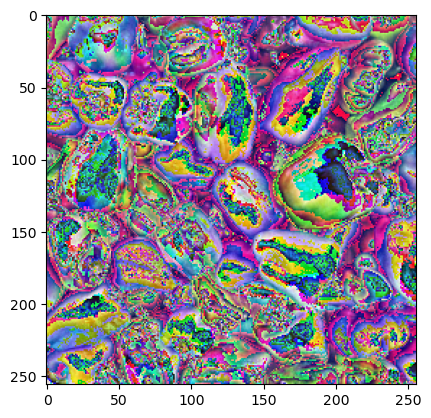

In [43]:
to_pil = transforms.functional.to_pil_image
    
import matplotlib.pyplot as plt
plt.imshow(to_pil(train_dataset[3150]))
plt.show()
plt.imshow(to_pil(train_dataset[120]))
plt.show()
plt.imshow(to_pil(train_dataset[1390]))
plt.show()

In [25]:
def visualize(model, dataset, idxs):
    with torch.no_grad():
        for i in idxs:
            plt.imshow(dataset[i].numpy().transpose(1,2,0))
            plt.show()
            orig_img_on_device = dataset[i].unsqueeze(0).to(device)
            print(orig_img_on_device.count_nonzero())
            decoded_img = model(orig_img_on_device).cpu().detach().squeeze(0)
            plt.imshow(decoded_img.permute(1, 2, 0))
            plt.show()


def train(model, optimizer, criterion,
          dataloaders: Dict[str, DataLoader], epochs,
          phases: List[str] = ["train", "val"], device = None,
          imshow_period: int = 10, save_model_period: int = 10):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-' * 10)
        
        for phase in phases:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()
            else:
                phase_err_msg = 'Phases cannot contain a phase ' \
                                'other than "train" or "val".'
                raise ValueError(phase_err_msg)
            
            epoch_loss = 0

            batch_pbar = tqdm(
                dataloaders[phase],
                total=len(dataloaders[phase]))
                        
            with torch.set_grad_enabled(model.training):
                for img in batch_pbar:
                    img = img.to(device)
                    img_decoded = model(img)

                    loss = criterion(img_decoded, img)
                    epoch_loss += loss
                    
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    progress_string = f"batch mse loss: {loss:.3f}"
                    batch_pbar.set_description(progress_string)
                    # maybe batch_pbar.set_postfix
            
            model.eval()
            if epoch % imshow_period == 0:
                visualize(model, train_dataset, idxs = [0])
            if epoch % save_model_period == 0:
                date_str = datetime.datetime.now().isoformat(timespec='minutes') 
                PATH = f"WIP__residual_decoder__{up_func_name}" \
                       f"__B_{B}__{epoch}_epoch__{date_str}.pt"
                torch.save(model.state_dict(), PATH)
                
    model.eval()

In [44]:
dummy_datasets = {"train": train_dataset, "val": train_dataset}
dummy_dataloaders = {
    "train": DataLoader(train_dataset, batch_size = 64, shuffle = True),
    "val": DataLoader(train_dataset, batch_size = 128, shuffle = False)}

In [16]:
def denormalize(img: torch.Tensor, means: List[int], stds: List[int]):
    result = torch.zeros_like(img)
    for i, (chan, mean, std) in enumerate(zip(img, means, stds)):
        result[i] = chan * std + mean
    return result


def denormalize_imagenet(img: torch.Tensor):
    imagenet_mean = [0.485, 0.456, 0.406]
    imagenet_std = [0.229, 0.224, 0.225]
    return denormalize(img, imagenet_mean, imagenet_std)

In [28]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# B = 6

# up_func_name = "upsample"
# resnet_autoencoder = create_resnet_autoencoder(
#     resnet18(weights=ResNet18_Weights.DEFAULT),
#     up_func_name = up_func_name,
#     B=B,
# ).to(device)
# # resnet_autoencoder.freeze_encoder()
# optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
# criterion = torch.nn.MSELoss() 

# epochs = 100


In [19]:
LOAD_PATH = "/kaggle/working/residual_decoder__upsample__B_6__16_epochs_2023-06-08T02:29.pt"

LOAD_PATH = "weights\\residual_decoder__upsample__B_6__63_epochs_2023-06-08T05_56.pt"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
B = 6

up_func_name = "upsample"
resnet_autoencoder = create_resnet_autoencoder(
    resnet18(weights=ResNet18_Weights.DEFAULT),
    up_func_name = up_func_name,
    B=B,
).to(device)
resnet_autoencoder.load_state_dict(torch.load(LOAD_PATH, map_location=torch.device(device)))
optimizer = torch.optim.Adam(resnet_autoencoder.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 

epochs = 40

Epoch 1/40
----------


batch mse loss: 0.109: 100%|██████████| 258/258 [04:30<00:00,  1.05s/it]


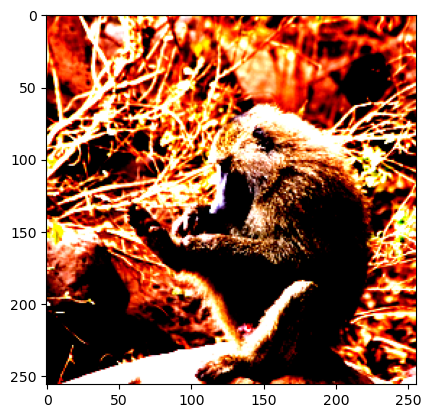

tensor(196608, device='cuda:0')


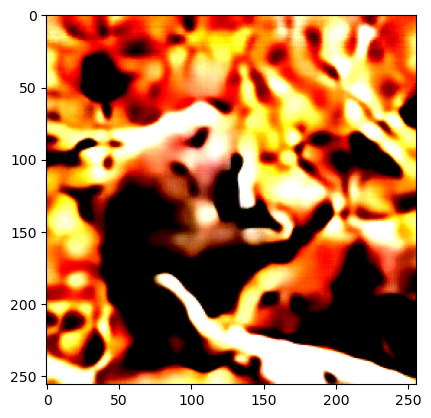

Epoch 2/40
----------


batch mse loss: 0.240: 100%|██████████| 258/258 [04:03<00:00,  1.06it/s]


Epoch 3/40
----------


batch mse loss: 0.132: 100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


Epoch 4/40
----------


batch mse loss: 0.171: 100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


Epoch 5/40
----------


batch mse loss: 0.084: 100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


Epoch 6/40
----------


batch mse loss: 0.072: 100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


Epoch 7/40
----------


batch mse loss: 0.099: 100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


Epoch 8/40
----------


batch mse loss: 0.101: 100%|██████████| 258/258 [03:53<00:00,  1.11it/s]


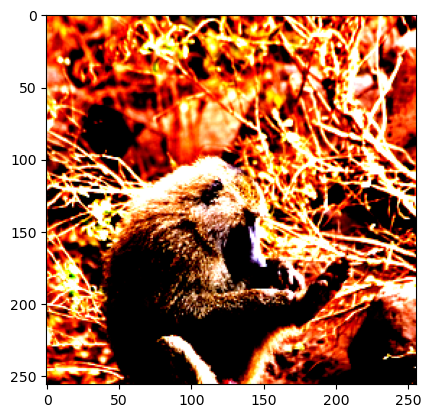

tensor(196608, device='cuda:0')


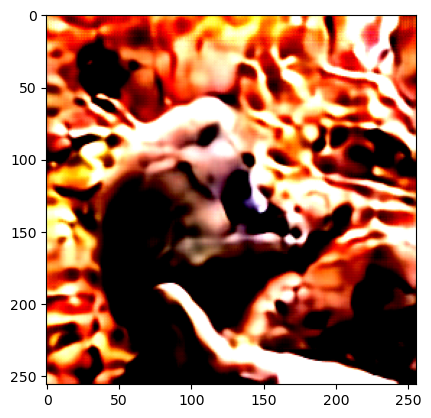

Epoch 9/40
----------


batch mse loss: 0.162: 100%|██████████| 258/258 [03:57<00:00,  1.09it/s]


Epoch 10/40
----------


batch mse loss: 0.078: 100%|██████████| 258/258 [03:49<00:00,  1.13it/s]


Epoch 11/40
----------


batch mse loss: 0.081: 100%|██████████| 258/258 [03:51<00:00,  1.11it/s]


Epoch 12/40
----------


batch mse loss: 0.060: 100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


Epoch 13/40
----------


batch mse loss: 0.056: 100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


Epoch 14/40
----------


batch mse loss: 0.079: 100%|██████████| 258/258 [03:54<00:00,  1.10it/s]


Epoch 15/40
----------


batch mse loss: 0.109: 100%|██████████| 258/258 [03:57<00:00,  1.09it/s]


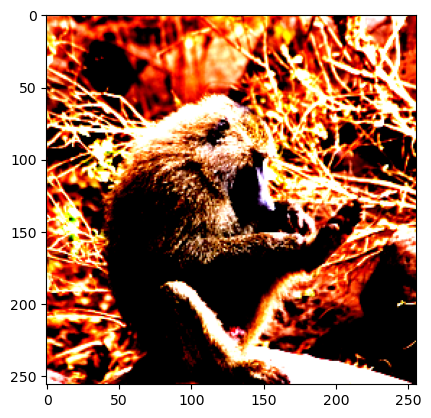

tensor(196608, device='cuda:0')


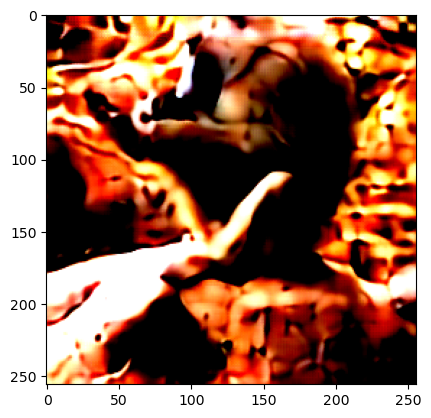

Epoch 16/40
----------


batch mse loss: 0.136: 100%|██████████| 258/258 [04:03<00:00,  1.06it/s]


Epoch 17/40
----------


batch mse loss: 0.067: 100%|██████████| 258/258 [03:55<00:00,  1.10it/s]


Epoch 18/40
----------


batch mse loss: 0.085: 100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


Epoch 19/40
----------


batch mse loss: 0.108: 100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


Epoch 20/40
----------


batch mse loss: 0.077: 100%|██████████| 258/258 [03:51<00:00,  1.11it/s]


Epoch 21/40
----------


batch mse loss: 0.062: 100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


Epoch 22/40
----------


batch mse loss: 0.059: 100%|██████████| 258/258 [03:51<00:00,  1.11it/s]


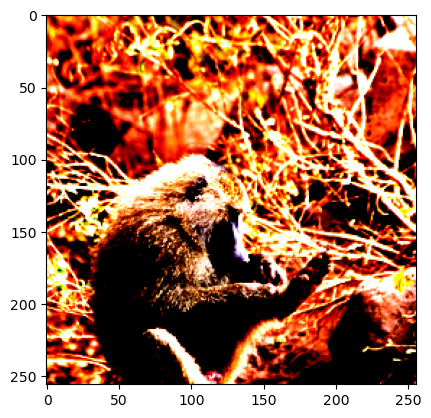

tensor(196608, device='cuda:0')


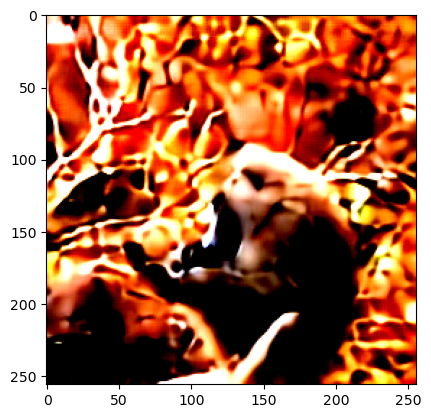

Epoch 23/40
----------


batch mse loss: 0.083: 100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


Epoch 24/40
----------


batch mse loss: 0.048: 100%|██████████| 258/258 [03:51<00:00,  1.11it/s]


Epoch 25/40
----------


batch mse loss: 0.043: 100%|██████████| 258/258 [03:50<00:00,  1.12it/s]


Epoch 26/40
----------


batch mse loss: 0.055:  65%|██████▍   | 167/258 [02:31<01:20,  1.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

batch mse loss: 0.056: 100%|██████████| 258/258 [03:52<00:00,  1.11it/s]


Epoch 32/40
----------


batch mse loss: 0.067: 100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


Epoch 33/40
----------


batch mse loss: 0.041: 100%|██████████| 258/258 [03:51<00:00,  1.12it/s]


Epoch 34/40
----------


batch mse loss: 0.065: 100%|██████████| 258/258 [03:48<00:00,  1.13it/s]


Epoch 35/40
----------


batch mse loss: 0.049: 100%|██████████| 258/258 [03:49<00:00,  1.13it/s]


Epoch 36/40
----------


batch mse loss: 0.059: 100%|██████████| 258/258 [03:49<00:00,  1.13it/s]


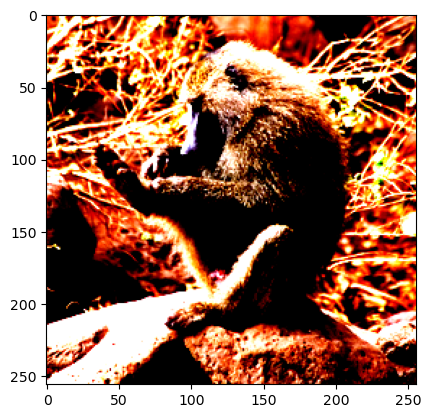

tensor(196608, device='cuda:0')


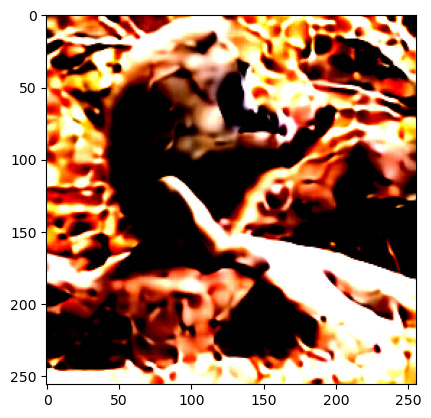

Epoch 37/40
----------


batch mse loss: 0.039: 100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


Epoch 38/40
----------


batch mse loss: 0.070: 100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


Epoch 39/40
----------


batch mse loss: 0.046: 100%|██████████| 258/258 [03:49<00:00,  1.12it/s]


Epoch 40/40
----------


batch mse loss: 0.068: 100%|██████████| 258/258 [03:58<00:00,  1.08it/s]


In [45]:
train(resnet_autoencoder, optimizer, criterion,
      dummy_dataloaders, epochs, phases = ["train"],
      save_model_period  = 7, imshow_period = 7)

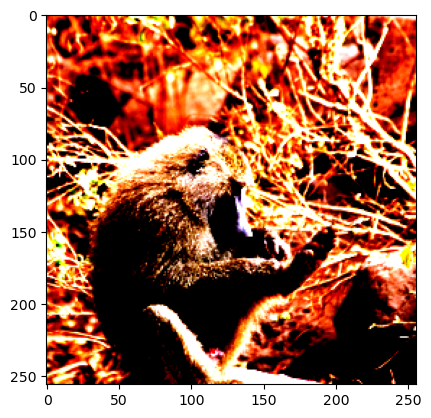

tensor(196608, device='cuda:0')


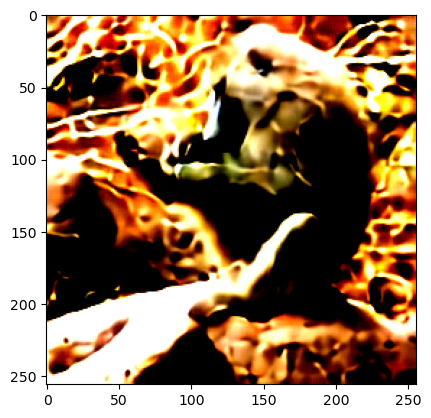

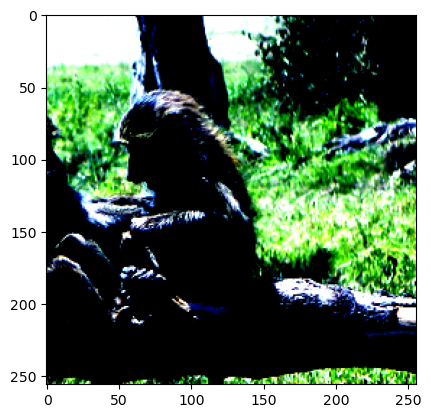

tensor(196608, device='cuda:0')


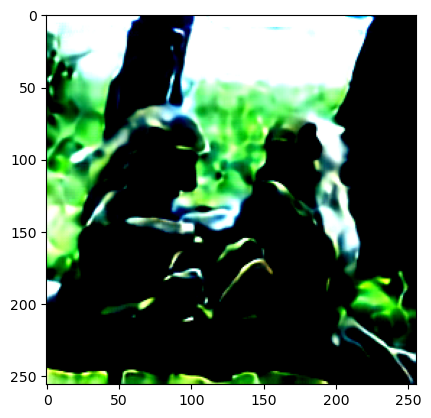

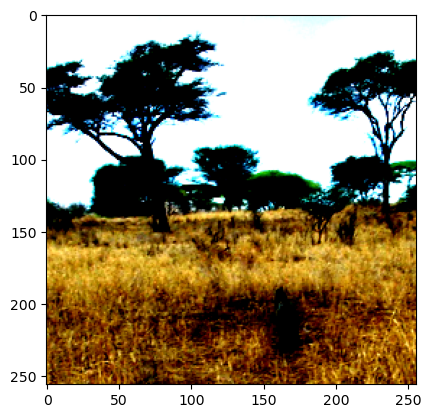

tensor(196608, device='cuda:0')


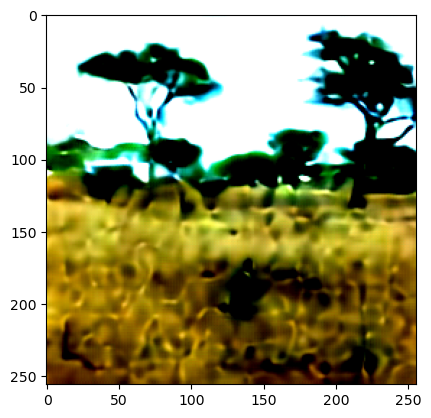

In [46]:
resnet_autoencoder.eval()
visualize(resnet_autoencoder, train_dataset, [0, 5, 10])

In [47]:
def show_dir_imgs(dir_name: str, model: NeuralImageCompressor, scale_factor: int = 3, data_transform = None) -> None:
    fig, axs = plt.subplots(2, 3, dpi=80)
    plt.axis('off')


    for i, img_name in enumerate(os.listdir(dir_name)):
        image_path = os.path.join(dir_name, img_name)
        image = skimage.io.imread(image_path)
        image = Image.fromarray(image)
        if data_transform is not None:
            image = data_transform

        orig_img_on_device = image.unsqueeze(0).to(device)
        decoded_img = model(
            orig_img_on_device).cpu().detach().squeeze(0)
        
        axs[0, i].imshow(denormalize_imagenet(image).numpy().transpose(1,2,0))
        axs[1, i].imshow(denormalize_imagenet(decoded_img).permute(1, 2, 0))

    for ax in axs.flat:
        ax.set(xlabel='x-label', ylabel='y-label')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_size_inches(fig.get_size_inches()*scale_factor)  # double the default size

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


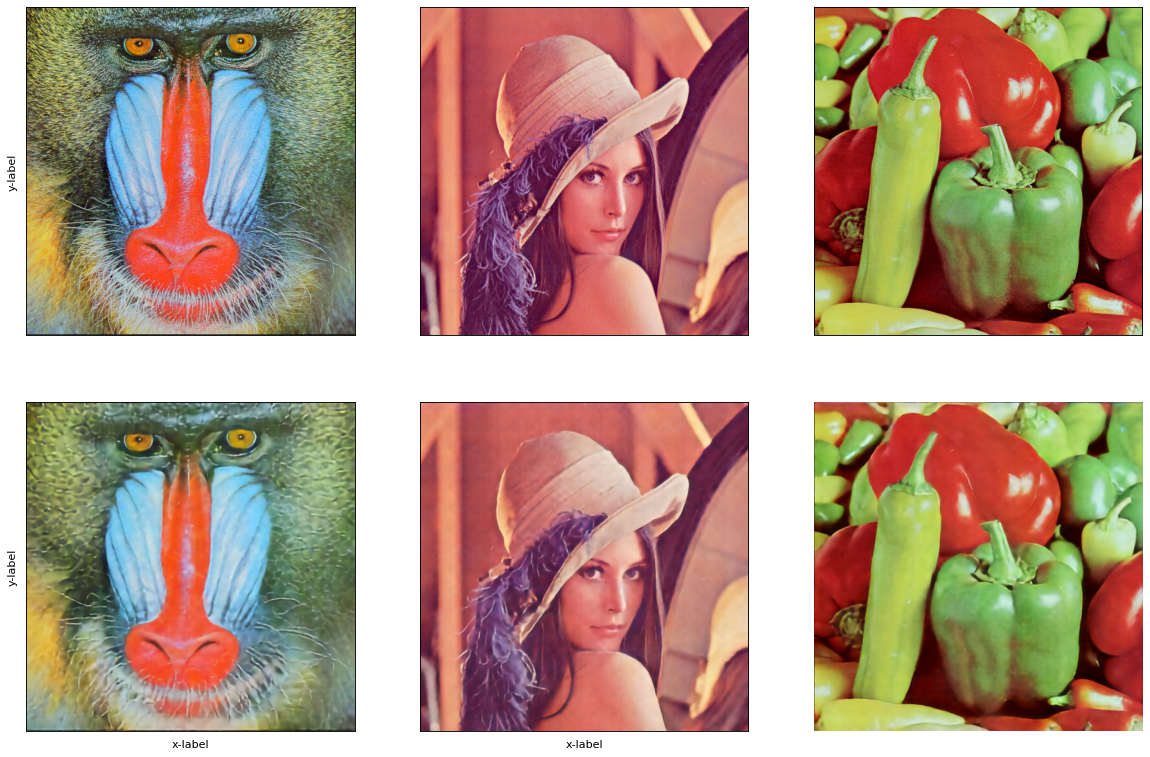

In [48]:
resnet_autoencoder.eval()
lab_imgs_path = "/kaggle/input/compression-lab-imgs"
lab_imgs_path = "compression-lab-imgs"

show_dir_imgs(lab_imgs_path, resnet_autoencoder)

In [ ]:
path_example = f"residual_decoder__{up_func_name}__B_{B}__{epochs}_epochs_{date_str}.pt"

In [48]:
epoch_bias = 23
date_str = datetime.datetime.now().isoformat(timespec='minutes') 

PATH = f"residual_decoder__{up_func_name}__B_{B}__{epochs + epoch_bias}_epochs_{date_str}.pt"

torch.save(resnet_autoencoder.state_dict(), PATH)

In [ ]:
resnet_autoencoder = create_resnet_autoencoder(
    resnet18(weights=ResNet18_Weights.DEFAULT),
    up_func_name =up_func_name,
    B = B)

resnet_autoencoder.load_state_dict(torch.load(PATH))